## Import libraries, functions and dataset

In [118]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error

# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

import warnings
warnings.filterwarnings("ignore")


In [119]:
file_path = "../data/ObesityDataSet_Clean.csv"
df = pd.read_csv(file_path)

#### Functions from exercise classes

In [120]:
# Exercise 7 

def bmplot(yt, xt, X):
    """
    Function plots matrix X as image with white background, black grid lines, and dark blue for selected cells.
    """
    plt.imshow(X, interpolation="none", cmap="Blues", aspect="equal", vmin=0, vmax=1)
    plt.xticks(range(0, len(xt)), xt)
    plt.yticks(range(0, len(yt)), yt)
    plt.gca().set_facecolor("white")
    for i in range(0, len(yt)):
        plt.axhline(i - 0.5, color="black")
    for i in range(0, len(xt)):
        plt.axvline(i - 0.5, color="black")
    plt.grid(False)
    
def plot_seq_feature_results(fold_results, feature_names):
    num_folds = len(fold_results)
    
    # Final summary heatmap
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"width_ratios": [2, 1]})

    # Left: Outer test MSEs
    outer_mses = [res["outer_test_mse"] for res in fold_results]
    axes[0].bar(range(1, num_folds + 1), outer_mses, color='tab:blue')
    axes[0].set_title("Outer test MSEs per fold")
    axes[0].set_xlabel("Fold")
    axes[0].set_ylabel("Outer test MSE")
    axes[0].grid(True, axis='y')
    
    # Right: Feature usage summary
    summary = np.zeros((len(feature_names), num_folds))
    for i, res in enumerate(fold_results):
        for feat in res["features"]:
            summary[feature_names.index(feat), i] = 1

    bmplot(feature_names, range(num_folds), summary)
    axes[1].set_title("Feature usage across folds")
    axes[1].set_xlabel("Outer folds")
    axes[1].set_ylabel("Features")
    plt.tight_layout()
    plt.show()

def sequential_feature_selection(X, y, outer_folds=10, inner_folds=10, random_state=42, regularization_step=1.0):
    CV_outer = KFold(n_splits=outer_folds, shuffle=True, random_state=random_state)

    fold_results = []  # store per-fold feature paths & errors
    outer_test_mse = []

    for outer_train_idx, outer_test_idx in CV_outer.split(X):
        # Split X and y into training/testing data for this outer fold
        # Name them X_train_outer, X_test_outer, y_train_outer, y_test_outer
        X_train_outer, X_test_outer = X.iloc[outer_train_idx], X.iloc[outer_test_idx]
        y_train_outer, y_test_outer = y.iloc[outer_train_idx], y.iloc[outer_test_idx]

        selected_features = []
        mse_per_iteration = []
        remaining_features = list(X.columns)
        best_mse = np.inf

        # Feature addition while-loop, keep adding features until no improvement
        while remaining_features:
            feature_mse = {}

            for feat in remaining_features:
                candidate_features = selected_features + [feat]

                # inner CV
                CV_inner = KFold(n_splits=inner_folds, shuffle=True, random_state=random_state)
                inner_mse = []

                for inner_train_idx, inner_test_idx in CV_inner.split(X_train_outer):

                    # Split X_train_outer and y_train_outer into training/testing data for this inner fold.
                    # Name them X_train_inner, X_test_inner, y_train_inner, y_test_inner
                    X_train_inner, X_test_inner = X_train_outer.iloc[inner_train_idx], X_train_outer.iloc[inner_test_idx]
                    y_train_inner, y_test_inner = y_train_outer.iloc[inner_train_idx], y_train_outer.iloc[inner_test_idx]
                    
                    # Create Linear Regression model, fit, and predict on the inner sets
                    # - save predictions as y_test_inner_pred.
                    # Remember to only take the candidate_features into consideration.
                    scaler = StandardScaler()
                    X_train_inner[candidate_features] = scaler.fit_transform(X_train_inner[candidate_features])
                    X_test_inner[candidate_features] = scaler.transform(X_test_inner[candidate_features])

                    model = Ridge(alpha=regularization_step, fit_intercept=True)
                    model.fit(X_train_inner[candidate_features], y_train_inner)
                    y_test_inner_pred = model.predict(X_test_inner[candidate_features])
        
                    # Add score for this fold
                    inner_mse.append(mean_squared_error(y_test_inner, y_test_inner_pred))

                # Save average MSE with this feature added
                feature_mse[feat] = np.mean(inner_mse)

            # pick best new feature
            best_feat = min(feature_mse, key=feature_mse.get)
            best_feat_mse = feature_mse[best_feat]

            # If best feature improves MSE, add it
            if best_feat_mse < best_mse:
                selected_features.append(best_feat)
                mse_per_iteration.append(best_feat_mse)
                best_mse = best_feat_mse
                remaining_features.remove(best_feat)

            else: # No improvement - get actual test MSE for outer loop, with best feature set.
                # Create Linear Regression model, fit, and predict on the outer sets
                # - save predictions as y_test_outer_pred.
                # Remember to only take the selected_features into consideration.
                scaler = StandardScaler()
                X_train_outer[selected_features] = scaler.fit_transform(X_train_outer[selected_features])
                X_test_outer[selected_features] = scaler.transform(X_test_outer[selected_features])

                model = LinearRegression(fit_intercept=True)
                model.fit(X_train_outer[selected_features], y_train_outer)
                y_test_outer_pred = model.predict(X_test_outer[selected_features])

                outer_test_mse = mean_squared_error(y_test_outer, y_test_outer_pred)
                break # Break out of while loop

        fold_results.append({
            "mse": mse_per_iteration,
            "features": selected_features,
            "outer_test_mse": outer_test_mse
        })
    return fold_results

# Exercise 8

def setup_storage_for_experiment(K_outer, K_inner, num_hyperparams):
    # Setup storage for the optimal hyperparameters found from the inner CV
    optimal_hyperparameters = np.empty(K_outer)

    # Setup storage for model coefficients and errors for each experiment in all inner folds
    ws_inner = np.empty((M + 1, K_outer, K_inner, num_hyperparams))
    train_errors_inner = np.empty((K_outer, K_inner, num_hyperparams))
    test_errors_inner = np.empty((K_outer, K_inner, num_hyperparams))

    # Setup storage for model coefficients for each experiment in all outer folds
    ws_outer = {
        'not regularized': np.empty((M + 1, K_outer)),
        'regularized': np.empty((M + 1, K_outer))
    }
    # Setup storage for errors as a dictionary
    errors_outer = {
        'train': {
            'baseline (no features)': np.empty((K_outer, 1)), 
            'not regularized': np.empty((K_outer, 1)),
            'regularized': np.empty((K_outer, 1))
        },
        'test': {
            'baseline (no features)': np.empty((K_outer, 1)), 
            'not regularized': np.empty((K_outer, 1)),
            'regularized': np.empty((K_outer, 1))
        }
    }
    return optimal_hyperparameters, ws_inner, train_errors_inner, test_errors_inner, ws_outer, errors_outer

def print_regularization_results(errors):
    # Display results
    print("Linear regression without regularization:")
    print(f"- Training error: \t{errors['train']['not regularized'].mean():.4f}")
    print(f"- Test error: \t\t{errors['test']['not regularized'].mean():.4f}")
    print(f"- R^2 train: \t\t{(errors['train']['baseline (no features)'].sum() - errors['train']['not regularized'].sum()) / errors['train']['baseline (no features)'].sum():.4f}")
    print(f"- R^2 test: \t\t{(errors['test']['baseline (no features)'].sum() - errors['test']['not regularized'].sum()) / errors['test']['baseline (no features)'].sum():.4f}\n")

    print("Regularized linear regression:")
    print(f"- Training error: \t{errors['train']['regularized'].mean():.4f}")
    print(f"- Test error: \t\t{errors['test']['regularized'].mean():.4f}")
    print(f"- R^2 train: \t\t{(errors['train']['baseline (no features)'].sum() - errors['train']['regularized'].sum()) / errors['train']['baseline (no features)'].sum():.4f}")
    print(f"- R^2 test: \t\t{(errors['test']['baseline (no features)'].sum() - errors['test']['regularized'].sum()) / errors['test']['baseline (no features)'].sum():.4f}\n")

def get_grid_points(x_min, x_max, y_min, y_max, delta=5e-3):
    # Create a grid of points with the specified resolution
    xx = np.arange(x_min, x_max, delta)
    yy = np.arange(y_min, y_max, delta)
    # Make a mesh-grid that spans the grid-range defined
    grid = np.stack(np.meshgrid(xx, yy))
    return grid, xx, yy

def plot_decision_boundary(predict_function, X, threshold=None, ax=None, fig=None, cmap='RdBu_r'):
    # Set grid range based on the data
    grid_range = [X[:, 0].min(), X[:, 0].max(), X[:, 1].min(), X[:, 1].max()]  # [x_min, x_max, y_min, y_max]
    # Add 10% margin to the grid range to ensure points on the edge are included
    margin_x = 0.1 * (grid_range[1] - grid_range[0])
    margin_y = 0.1 * (grid_range[3] - grid_range[2])
    grid_range[0] -= margin_x
    grid_range[1] += margin_x
    grid_range[2] -= margin_y
    grid_range[3] += margin_y

    # Get grid points
    grid, xx, yy = get_grid_points(*grid_range, delta=5e-3)
    # Reshape grid to a list of points
    grid_points = np.reshape(grid, (2, -1)).T

    # Compute model predictions on the grid points (i.e. the probability of class 1)
    grid_predictions = predict_function(grid_points)

    # Reshape the predictions back to the grid shape
    decision_boundary = np.reshape(grid_predictions, (len(yy), len(xx)))

    # Plot the decision boundary
    img = ax.imshow(decision_boundary, extent=grid_range, origin='lower', cmap=cmap, alpha=0.5, vmin=0, vmax=1)
    fig.colorbar(img, ax=ax)
    if threshold is not None:
        ax.contour(grid[0], grid[1], decision_boundary, levels=[threshold], colors='k')
    ax.grid(False)
    ax.set_aspect('auto')

## Model preparation and feature engineering

In [121]:
def dataset_setup(df, all_attributes=False):
    if(all_attributes):
        #X = df.drop(columns=["Weight", "NObeyesdad"])
        X = df.drop(columns="Weight")

    else:
        #attributes_used = ["Age", "Gender", "Height", "family_history_with_overweight", "CAEC"]
        # this choice comes from the ones chosen on report 1

        attributes_used = df.drop(columns=["Weight", "FAVC", "NCP", "SMOKE", "CH2O", "SCC", "TUE"]).columns
        # testing removing this columns in particular because they were not chosen by CV when I did one hot encoding on all variables
        
        X = df[attributes_used]

    return X, df["Weight"]

#### Feature engineering
Run the cell according to the X you want to consider

In [122]:
# considering only the features from report 1
attributes_used = ["Age", "Gender", "Height", "family_history_with_overweight", "CAEC"]
X = df[attributes_used]

X = pd.get_dummies(X, columns=["Gender", "family_history_with_overweight", "CAEC"], drop_first=True, dtype=int)
y = df["Weight"]

# Get number of samples and features
N, M = X.shape
print(f"Number of samples: {N}, number of features: {M}")

X.head()

Number of samples: 2111, number of features: 7


,Age,Height,Gender_Male,family_history_with_overweight_yes,CAEC_Frequently,CAEC_Sometimes,CAEC_no
0,21,1.62,0,1,0,1,0
1,21,1.52,0,1,0,1,0
2,23,1.80,1,1,0,1,0
3,27,1.80,1,0,0,1,0
4,22,1.78,1,0,0,1,0


### 1 Considering all features - ordinal encoding for some categorical features

In [123]:
# considering all features - ordinal encoding for some categorical features

# FHWO, FAVC, SMOKE, SCC = 0/1, yes = 1, no = 0 - usar replace nestas variáveis para substituir o yes e o no por 1 e 0
# FCVC = 1/2/3 - manter
# NCP = 1/2/3 - manter
# MTRANS = One Hot Encoding
# NObeyesdad = substituir a ordem por [1, 2, 3, 4, 5, 6, 7]
# ordem ["Insufficient Weight", "Normal Weight", "Overweright_Level_I", "Overweight_Level_2", "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"]

X, y = dataset_setup(df, all_attributes=False)

ordinal_mappings = {
    "NObeyesdad": {
        "Insufficient_Weight": 1,
        "Normal_Weight": 2,
        "Overweight_Level_I": 3,
        "Overweight_Level_II": 4,
        "Obesity_Type_I": 5,
        "Obesity_Type_II": 6,
        "Obesity_Type_III": 7
    },
    "FAVC": {
        "yes": 1,
        "no": 0
    },
    "SMOKE": {
        "yes": 1,
        "no": 0
    },
    "SCC": {
        "yes": 1,
        "no": 0
    },
    "family_history_with_overweight": {
        "yes": 1,
        "no": 0
    },
    "CAEC": {
        "no": 0,
        "Sometimes": 1,
        "Frequently": 2,
        "Always": 3
    },

    "CALC": {
        "no": 0,
        "Sometimes": 1,
        "Frequently": 2,
        "Always": 3
    },

    "Gender": {
        "Male": 0,
        "Female": 1
    }
}

for col, mapping in ordinal_mappings.items():
    if col in X.columns:
        X[col] = X[col].replace(mapping)

X = pd.get_dummies(X, columns=["MTRANS"], drop_first=True, dtype=int)
X.Age = np.log(X.Age) # because age is right skewed

# Get number of samples and features
N, M = X.shape
print(f"Number of samples: {N}, number of features: {M}")

X.head()

Number of samples: 2111, number of features: 13


,Gender,Age,Height,family_history_with_overweight,FCVC,CAEC,FAF,CALC,NObeyesdad,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,1,3.044522,1.62,1,2,1,0,0,2,0,0,1,0
1,1,3.044522,1.52,1,3,1,3,1,2,0,0,1,0
2,0,3.135494,1.80,1,2,1,2,2,2,0,0,1,0
3,0,3.295837,1.80,0,3,1,2,2,3,0,0,0,1
4,0,3.091042,1.78,0,2,1,0,1,4,0,0,1,0


### 2 Considering all features, simple one hot encoding for all

In [134]:
# considering all features - simple one hot encoding for all
X, y = dataset_setup(df, all_attributes=True)
categorical_attributes = X.drop(columns=["Age", "Height"]).columns
X = pd.get_dummies(X, columns=categorical_attributes, drop_first=True, dtype=int)
X.Age = np.log(X.Age) # because age is right skewed

# Get number of samples and features
N, M = X.shape
print(f"Number of samples: {N}, number of features: {M}")

X.head()

Number of samples: 2111, number of features: 34


,Age,Height,Gender_Male,family_history_with_overweight_yes,FAVC_yes,FCVC_2,FCVC_3,NCP_2,NCP_3,CAEC_Frequently,...,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad_Normal_Weight,NObeyesdad_Obesity_Type_I,NObeyesdad_Obesity_Type_II,NObeyesdad_Obesity_Type_III,NObeyesdad_Overweight_Level_I,NObeyesdad_Overweight_Level_II
0,3.044522,1.62,0,1,0,1,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
1,3.044522,1.52,0,1,0,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0
2,3.135494,1.80,1,1,0,1,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
3,3.295837,1.80,1,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
4,3.091042,1.78,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


### 3 Considering selected features, simple one hot encoding for all

In [125]:
# considering all features - simple one hot encoding for all
X, y = dataset_setup(df, all_attributes=False)
categorical_attributes = X.drop(columns=["Age", "Height"]).columns
X = pd.get_dummies(X, columns=categorical_attributes, drop_first=True, dtype=int)
X.Age = np.log(X.Age) # because age is right skewed

# Get number of samples and features
N, M = X.shape
print(f"Number of samples: {N}, number of features: {M}")

X.head()

Number of samples: 2111, number of features: 25


,Age,Height,Gender_Male,family_history_with_overweight_yes,FCVC_2,FCVC_3,CAEC_Frequently,CAEC_Sometimes,CAEC_no,FAF_1,...,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad_Normal_Weight,NObeyesdad_Obesity_Type_I,NObeyesdad_Obesity_Type_II,NObeyesdad_Obesity_Type_III,NObeyesdad_Overweight_Level_I,NObeyesdad_Overweight_Level_II
0,3.044522,1.62,0,1,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
1,3.044522,1.52,0,1,0,1,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,3.135494,1.80,1,1,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
3,3.295837,1.80,1,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
4,3.091042,1.78,1,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1


## Simple Linear Regression

In [135]:
CV_kfold = KFold(n_splits=10, shuffle=True, random_state=42)
fold_errors = []

for fold, (train_index, test_index) in enumerate(CV_kfold.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Standardize features
    mu = X_train.mean(axis=0)
    sigma = X_train.std(axis=0)
    X_train = (X_train - mu) / sigma
    X_test = (X_test - mu) / sigma

    # Create and fit model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # Compute errors
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)

    print(f"Fold {fold + 1}: Train RMSE: {train_error:.4f}, Test RMSE: {test_error:.4f}")
    fold_errors.append({
        "train_error": train_error,
        "test_error": test_error
    })

# Analyze results
generalisation_error = np.mean([fe["test_error"] for fe in fold_errors])
print(f"\nEstimated generalisation error (average test RMSE over folds): {generalisation_error:.4f}")

Fold 1: Train RMSE: 23.7642, Test RMSE: 26.9459
Fold 2: Train RMSE: 24.2208, Test RMSE: 23.6816
Fold 3: Train RMSE: 23.8279, Test RMSE: 26.2418
Fold 4: Train RMSE: 24.0197, Test RMSE: 24.9293
Fold 5: Train RMSE: 24.6635, Test RMSE: 18.7397
Fold 6: Train RMSE: 24.3917, Test RMSE: 21.2981
Fold 7: Train RMSE: 23.8731, Test RMSE: 25.9346
Fold 8: Train RMSE: 24.1832, Test RMSE: 23.1120
Fold 9: Train RMSE: 23.5159, Test RMSE: 29.3747
Fold 10: Train RMSE: 23.5312, Test RMSE: 28.9769

Estimated generalisation error (average test RMSE over folds): 24.9235


## Introduce a regularisation parameter λ

In [136]:
lambdas = np.logspace(-22, 10, 30)
print("Testing lambdas:", lambdas)

Testing lambdas: [1.00000000e-22 1.26896100e-21 1.61026203e-20 2.04335972e-19
 2.59294380e-18 3.29034456e-17 4.17531894e-16 5.29831691e-15
 6.72335754e-14 8.53167852e-13 1.08263673e-11 1.37382380e-10
 1.74332882e-09 2.21221629e-08 2.80721620e-07 3.56224789e-06
 4.52035366e-05 5.73615251e-04 7.27895384e-03 9.23670857e-02
 1.17210230e+00 1.48735211e+01 1.88739182e+02 2.39502662e+03
 3.03919538e+04 3.85662042e+05 4.89390092e+06 6.21016942e+07
 7.88046282e+08 1.00000000e+10]


Introduce a regularisation parameter λ as discussed in 14 of the lecture notes, and estimate the generalization error for different values of λ. Specifically, choose a reasonable range of values of λ (ideally one where the generalization error first drop and then increases), and for each value use K = 10 fold cross-validation (algorithm 5) to estimate the generalization error. Include a figure of the estimated generalization error as a function of λ in the report and briefly discuss the result.

In [137]:
lambdas = np.logspace(-6, 2, 30)
#lambdas = np.logspace(-100, 10, 13)
mean_train_errors, mean_test_errors = [], []

# k = 10 fold cross validation
for l in lambdas:
    fold_errors = []
    CV_kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    
    for fold, (train_index, test_index) in enumerate(CV_kfold.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Standardize features
        mu = X_train.mean(axis=0)
        sigma = X_train.std(axis=0)
        X_train = (X_train - mu) / sigma
        X_test = (X_test - mu) / sigma

        model = Ridge(alpha=l)
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_test_pred  = model.predict(X_test)

        train_error = mean_squared_error(y_train, y_train_pred)
        test_error = mean_squared_error(y_test, y_test_pred)
        fold_errors.append((train_error, test_error))

    mean_train_errors.append(np.mean([fe[0] for fe in fold_errors]))
    mean_test_errors.append(np.mean([fe[1] for fe in fold_errors]))

    print(f"Lambda {l:.2e}: Train MSE: {mean_train_errors[-1]:.4f}, Test MSE: {mean_test_errors[-1]:.4f}")

Lambda 1.00e-06: Train MSE: 23.9991, Test MSE: 24.9235
Lambda 1.89e-06: Train MSE: 23.9991, Test MSE: 24.9235
Lambda 3.56e-06: Train MSE: 23.9991, Test MSE: 24.9235
Lambda 6.72e-06: Train MSE: 23.9991, Test MSE: 24.9235
Lambda 1.27e-05: Train MSE: 23.9991, Test MSE: 24.9235
Lambda 2.40e-05: Train MSE: 23.9991, Test MSE: 24.9235
Lambda 4.52e-05: Train MSE: 23.9991, Test MSE: 24.9235
Lambda 8.53e-05: Train MSE: 23.9991, Test MSE: 24.9235
Lambda 1.61e-04: Train MSE: 23.9991, Test MSE: 24.9235
Lambda 3.04e-04: Train MSE: 23.9991, Test MSE: 24.9235
Lambda 5.74e-04: Train MSE: 23.9991, Test MSE: 24.9235
Lambda 1.08e-03: Train MSE: 23.9991, Test MSE: 24.9234
Lambda 2.04e-03: Train MSE: 23.9991, Test MSE: 24.9234
Lambda 3.86e-03: Train MSE: 23.9991, Test MSE: 24.9234
Lambda 7.28e-03: Train MSE: 23.9991, Test MSE: 24.9234
Lambda 1.37e-02: Train MSE: 23.9991, Test MSE: 24.9234
Lambda 2.59e-02: Train MSE: 23.9991, Test MSE: 24.9233
Lambda 4.89e-02: Train MSE: 23.9991, Test MSE: 24.9232
Lambda 9.2

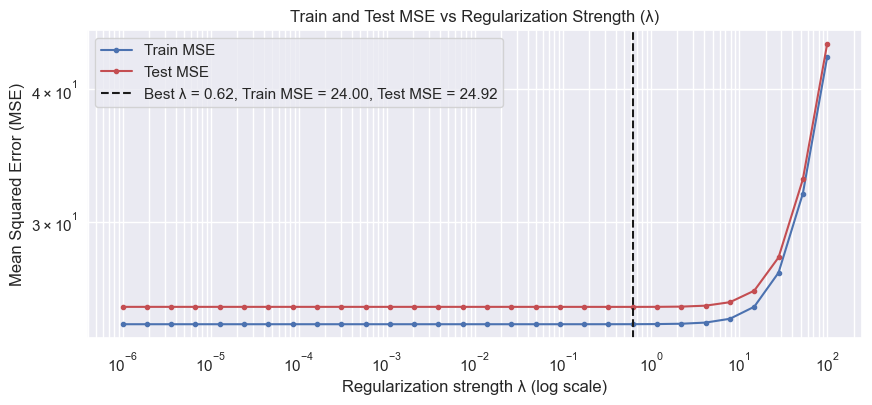

In [138]:
plt.figure(figsize=(10,4))
plt.loglog(lambdas, mean_train_errors, 'b.-', label="Train MSE")
plt.semilogx(lambdas, mean_test_errors, 'r.-', label="Test MSE")

best_lambda_idx = np.argmin(mean_test_errors)
best_lambda = lambdas[best_lambda_idx]
plt.axvline(best_lambda, color='k', linestyle='--', label=f"Best λ = {best_lambda:.2g}, Train MSE = {mean_train_errors[best_lambda_idx]:.2f}, Test MSE = {mean_test_errors[best_lambda_idx]:.2f}")

plt.title("Train and Test MSE vs Regularization Strength (λ)")
plt.xlabel("Regularization strength λ (log scale)")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid(True, which="both", ls="-")
plt.show()

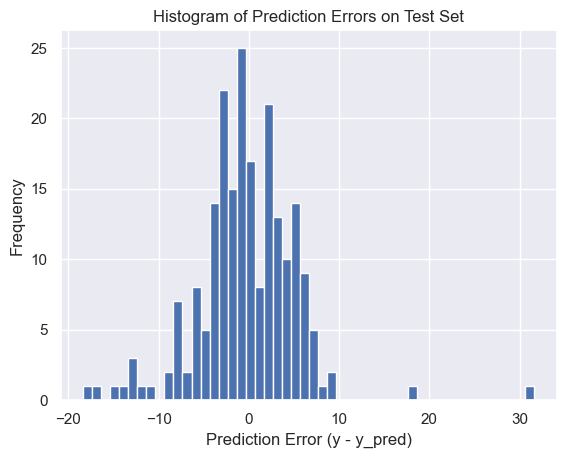

In [140]:
dif = y_test.values - y_test_pred
results_df = pd.DataFrame({
    "Sample_ID": test_index,
    "y": y[test_index],
    "y_train_pred": y_test_pred,
    "diff_test": dif
})

plt.hist(dif, bins=50)
plt.title("Histogram of Prediction Errors on Test Set")
plt.xlabel("Prediction Error (y - y_pred)")
plt.ylabel("Frequency")
plt.show()

## Selecting features

In [141]:
# Standardize whole dataset
mu = X.mean(axis=0)
sigma = X.std(axis=0)
X_std = (X - mu) / sigma

# Train final model
final_model = Ridge(alpha=best_lambda)
final_model.fit(X_std, y)

weights = final_model.coef_
bias = final_model.intercept_

for elem in zip(X.columns, weights):
    print(f"{elem[0]}: {elem[1]}")


Age: -0.715616033134116
Height: 9.015776108982934
Gender_Male: -0.3164115204639971
family_history_with_overweight_yes: -0.40442828950677984
FAVC_yes: -0.19968178427475328
FCVC_2: 0.5742571578411348
FCVC_3: 0.4659470918463091
NCP_2: -0.21997629149264522
NCP_3: -0.49246250704082944
CAEC_Frequently: 0.5434926412519254
CAEC_Sometimes: -0.3286617490384313
CAEC_no: -0.003008996761642574
SMOKE_yes: 0.07956552262580835
CH2O_2: 0.6898282656795371
CH2O_3: 0.1253954055039104
SCC_yes: -0.033436843996250985
FAF_1: 1.2518229936424226
FAF_2: 1.0793613019791153
FAF_3: 0.12169502735196511
TUE_1: 0.32068614121341077
TUE_2: 0.3741123972035601
CALC_Frequently: 0.35183833169326917
CALC_Sometimes: 1.5326593085407485
CALC_no: 1.06363732477001
MTRANS_Bike: -0.10119000216885302
MTRANS_Motorbike: -0.04223817231269135
MTRANS_Public_Transportation: -0.693316473395392
MTRANS_Walking: -0.21361906965652688
NObeyesdad_Normal_Weight: 4.93427257766467
NObeyesdad_Obesity_Type_I: 16.85125114722272
NObeyesdad_Obesity_Type